## Introduction

We will go through each step to build the \[\[7,1,3\]\] color code, also known as the Stane Code.



## Encoding

We can first start by preparing the logical qubit basis state. This circuit will prepare the logical basis state $|0\rangle_L$ which corresponds to the state/code word:


$$
\begin{align}
|0\rangle_L & = |0000000\rangle+|1010101\rangle+|0110011\rangle+|1100110\rangle \\
& +|0001111\rangle+|1011010\rangle+|0111100\rangle+|1101001\rangle, \notag \\
|1\rangle_L & = X_{1111111}|0\rangle_L \\
& = |1111111\rangle+|0101010\rangle+|1001100\rangle+|0011001\rangle \notag \\
& +|1110000\rangle+|0100101\rangle+|1000011\rangle+|0010110\rangle).
\end{align}
$$


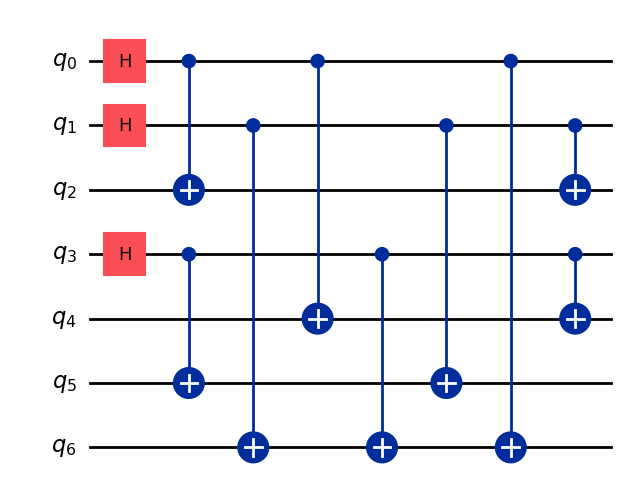

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qreg_q = QuantumRegister(7, "q")

# Encoding circuit to create the logical basis states
encodingcircuit = QuantumCircuit(qreg_q)
encodingcircuit.h(qreg_q[0])
encodingcircuit.h(qreg_q[1])
encodingcircuit.h(qreg_q[3])
encodingcircuit.cx(qreg_q[0], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[5])
encodingcircuit.cx(qreg_q[1], qreg_q[6])
encodingcircuit.cx(qreg_q[0], qreg_q[4])
encodingcircuit.cx(qreg_q[3], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[5])
encodingcircuit.cx(qreg_q[0], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[4])
encodingcircuit.draw('mpl', style='iqp')

Now, let's verify if we created the right logical state.

In [2]:
from qiskit.quantum_info import Statevector

# Returns the output statevector of the given circuit
statevec = Statevector.from_instruction(encodingcircuit.reverse_bits())
statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

As we can see, this is indeed the correct $|0\rangle_L$ logical state we want to prepare! However, the circuit taken from Quantinuum paper looks different. What's going on here? The extra 8th qubit here is to make sure such a logical state preparation subroutine is fault-tolerant (FT).

<img src="../pic/EncodingCircuit_Quantinuum.png" alt="drawing" width="400"/>

Let's try their circuit implementation.

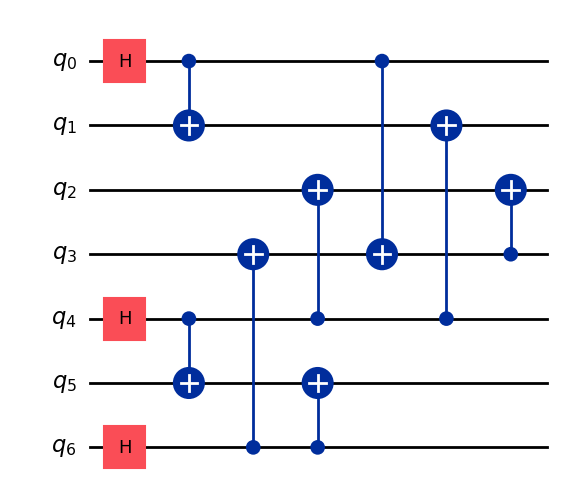

In [3]:
qreg = QuantumRegister(7, "q")

# Implement the quantum circuit from paper
quantinuum_circuit = QuantumCircuit(qreg)
quantinuum_circuit.h(qreg[0])
quantinuum_circuit.h(qreg[4])
quantinuum_circuit.h(qreg[6])
quantinuum_circuit.cx(qreg[0], qreg[1])
quantinuum_circuit.cx(qreg[4], qreg[5])
quantinuum_circuit.cx(qreg[6], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[2])
quantinuum_circuit.cx(qreg[6], qreg[5])
quantinuum_circuit.cx(qreg[0], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[1])
quantinuum_circuit.cx(qreg[3], qreg[2])
quantinuum_circuit.draw('mpl', style='iqp')

In [5]:
quantinuum_statevec = Statevector.from_instruction(quantinuum_circuit.reverse_bits())
quantinuum_statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

These still look different from previous results. So what's happening here is Quantinuum's paper [1] using a different index system (right below) to label their physical qubits compare to ours (left below) [2].

Standard index system  | Quantinuum's index system
- | - 
![](../pic/colorcode.png) | ![](../pic/quantinuum_colorcode.png)

The index mapping to double-check their implementation to the standard one is:

$$
\text{Quantinuum} \rightarrow \text{Standard}: \quad 1 \rightarrow 4, 2 \rightarrow 5, 3\rightarrow 7, 4 \rightarrow 6, 5 \rightarrow 1, 6 \rightarrow 3, 7 \rightarrow 2.
$$

Or in Python

$$
\text{Quantinuum} \rightarrow \text{Standard}: \quad 0 \rightarrow 3, 1 \rightarrow 4, 2\rightarrow 6, 3 \rightarrow 5, 4 \rightarrow 0, 5 \rightarrow 2, 6 \rightarrow 1.
$$

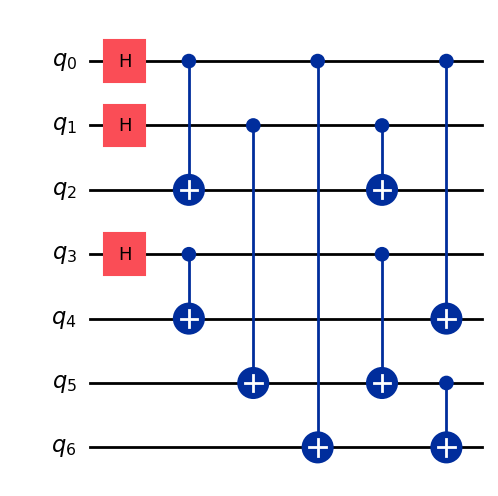

In [4]:
# Change index manually to verify Quantinuum's circuit
quantinuum_mapped_circuit = QuantumCircuit(qreg)
quantinuum_mapped_circuit.h(qreg[3])
quantinuum_mapped_circuit.h(qreg[0])
quantinuum_mapped_circuit.h(qreg[1])
quantinuum_mapped_circuit.cx(qreg[3], qreg[4])
quantinuum_mapped_circuit.cx(qreg[0], qreg[2])
quantinuum_mapped_circuit.cx(qreg[1], qreg[5])
quantinuum_mapped_circuit.cx(qreg[0], qreg[6])
quantinuum_mapped_circuit.cx(qreg[1], qreg[2])
quantinuum_mapped_circuit.cx(qreg[3], qreg[5])
quantinuum_mapped_circuit.cx(qreg[0], qreg[4])
quantinuum_mapped_circuit.cx(qreg[5], qreg[6])
quantinuum_mapped_circuit.draw('mpl', style='iqp')

In [6]:
quantinuum_mapped_statevec = Statevector.from_instruction(quantinuum_mapped_circuit.reverse_bits())
quantinuum_mapped_statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

Yes! It works. The two circuits are equivalent up to an index mapping. Once we verify this, we can just follow Quantinuum's index system.

## FT Implementation

According to Quantinuum's paper, they add one extra qubit and apply $Z_1Z_3Z_5$ parity check to make sure this state preparation step is actually fault-tolerant. If the measurement result is $0$, we successfully create the logical $|0 \rangle_L$ state and we can go to the next step. If not, repeat at most 3 times.

```Python
# Use FT circuit from Ref. [61] to prepare logical |0> (see Fig. 10) given 3 verification attempt. 
# Continue regardless of final success
for _ in range(3):
    state, prep_error = prep_zero()
    if prep_error ==0:
        break # break out of for loop if successful
```

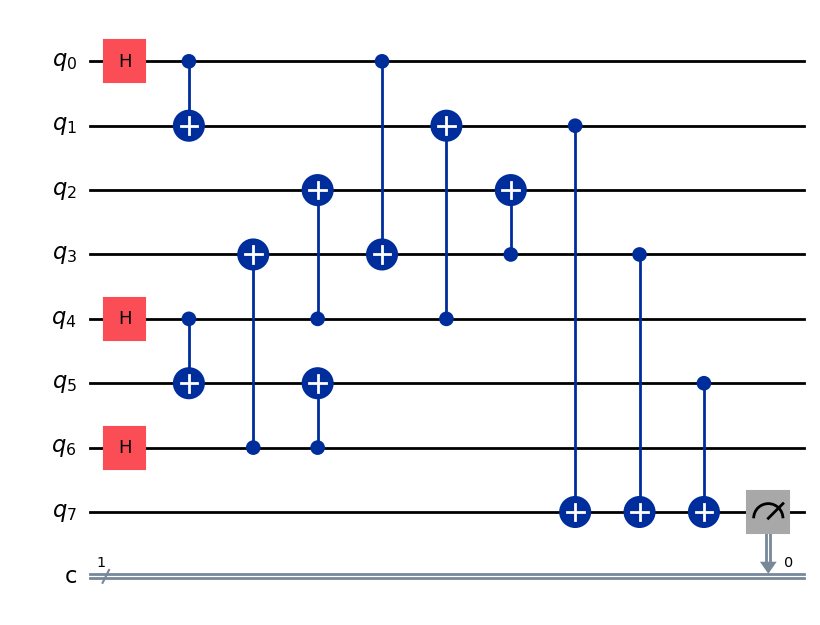

In [24]:
qreg = QuantumRegister(8, "q")
creg = ClassicalRegister(1, "c")

quantinuum_circuit = QuantumCircuit(qreg, creg)
quantinuum_circuit.h(qreg[0])
quantinuum_circuit.h(qreg[4])
quantinuum_circuit.h(qreg[6])
quantinuum_circuit.cx(qreg[0], qreg[1])
quantinuum_circuit.cx(qreg[4], qreg[5])
quantinuum_circuit.cx(qreg[6], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[2])
quantinuum_circuit.cx(qreg[6], qreg[5])
quantinuum_circuit.cx(qreg[0], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[1])
quantinuum_circuit.cx(qreg[3], qreg[2])

quantinuum_circuit.cx(qreg[1], qreg[7])
quantinuum_circuit.cx(qreg[3], qreg[7])
quantinuum_circuit.cx(qreg[5], qreg[7])
encode0LGate = quantinuum_circuit.to_instruction(label='encoding circuit')

quantinuum_circuit.measure(qreg[7], creg)
quantinuum_circuit.draw('mpl', style='iqp')

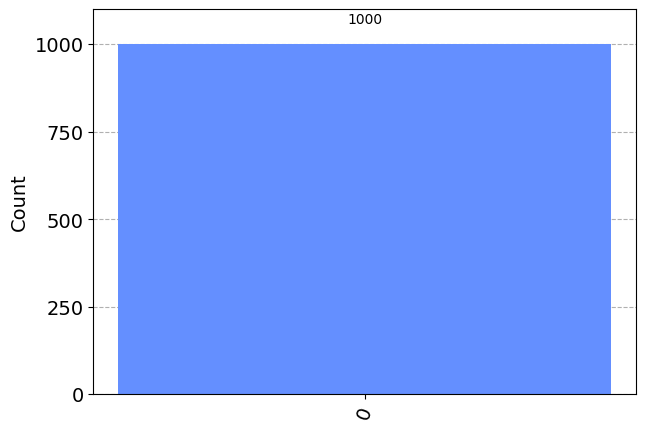

In [8]:
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
quantinuum_circ = transpile(quantinuum_circuit, simulator)

# Run and get counts
result = simulator.run(quantinuum_circ, shots=1000).result()
counts = result.get_counts(quantinuum_circ)
plot_histogram(counts, title='')

Here, we measure the encoding circuit 1000 times and the parity check always gives us $0$. Now, let's try a noisy simulator or manually inject an error in the circuit. See what happens.

In [9]:
from qiskit.providers.fake_provider import *

# Example 27-qubits fake backend with noise model
device_backend = FakeHanoi()

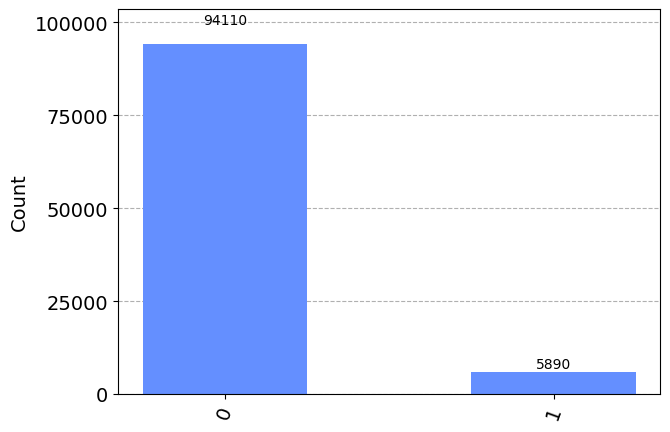

In [10]:
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city

# Specify noisy simulator
sim_noisy = AerSimulator.from_backend(device_backend)
# sim_noisy = AerSimulator.from_backend(FakeMumbai())
# sim_noisy = AerSimulator.from_backend(FakeSydney())
# sim_noisy = AerSimulator.from_backend(FakeToronto())
# sim_noisy = AerSimulator.from_backend(FakeTokyo())
# sim_noisy = AerSimulator.from_backend(FakeMontreal())
# sim_noisy = AerSimulator.from_backend(FakeCairo())

# Transpile for simulator
quantinuum_circ_noisy = transpile(quantinuum_circuit, sim_noisy, optimization_level=3)

# Run and get counts
noisy_result = sim_noisy.run(quantinuum_circ_noisy, shots=100000).result()
noisy_counts = noisy_result.get_counts(quantinuum_circ_noisy)
plot_histogram(noisy_counts, title='')

After apply this FT circuit to the `FakeHanoi()` backend, we see the probability of preparing such a logical state with no error on it is about $94\%$.

Since the circuit above wasn't truly FT as it didn't have the conditional reuse and reapplication of the encoding circuit, we need to then create a quantum circuit that does this:

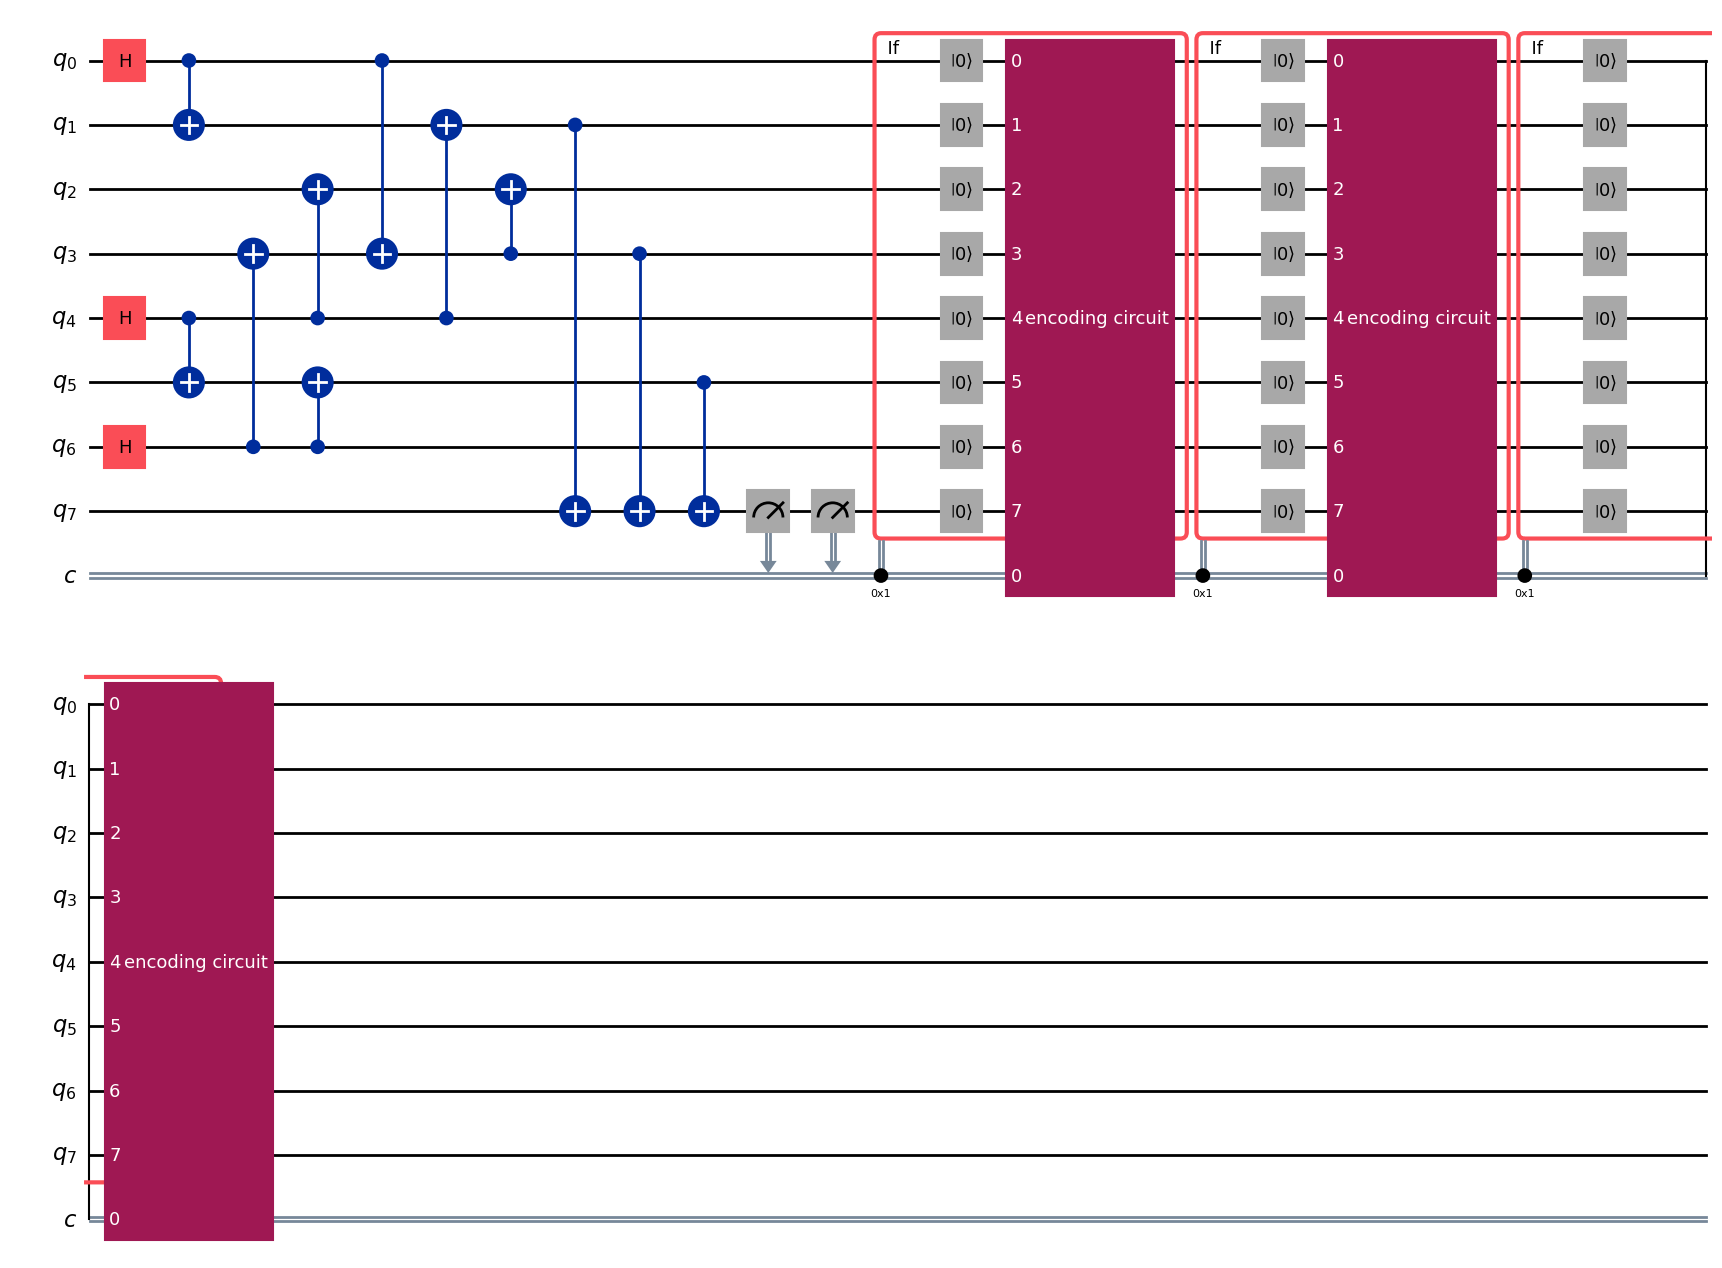

In [22]:
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit import IfElseOp
qreg = QuantumRegister(8, "q")
creg = ClassicalRegister(1, "c")

FTquantinuum_circuit = QuantumCircuit(qreg, creg)
FTquantinuum_circuit.append(encode0LGate, qreg, creg)
FTquantinuum_circuit.measure(7,0)

with FTquantinuum_circuit.if_test((creg, 1)):
    FTquantinuum_circuit.reset(qreg[:])
    FTquantinuum_circuit.append(encode0LGate, qreg, creg)
    FTquantinuum_circuit.measure(7,0)

with FTquantinuum_circuit.if_test((creg, 1)):
    FTquantinuum_circuit.reset(qreg[:])
    FTquantinuum_circuit.append(encode0LGate, qreg, creg)
    FTquantinuum_circuit.measure(7,0)

with FTquantinuum_circuit.if_test((creg, 1)):
    FTquantinuum_circuit.reset(qreg[:])
    FTquantinuum_circuit.append(encode0LGate, qreg, creg)
    FTquantinuum_circuit.measure(7,0)

FTquantinuum_circuit.decompose().draw('mpl', style="iqp")


In [31]:
# or one can call our built-in functions
from utils import prep_zero

circuit = prep_zero()
# circuit.decompose().draw('mpl', style="iqp")

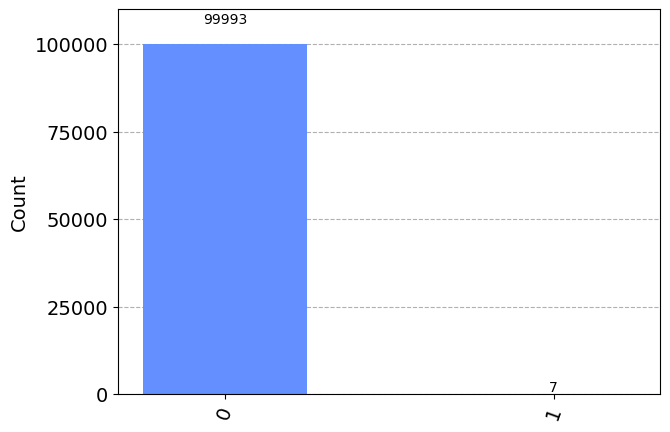

In [30]:
# now lets simulate this FT circuit and see if we can reduce the number of 1 states

quantinuum_circ_FT = transpile(circuit, sim_noisy, optimization_level=3)
noisy_result_FT = sim_noisy.run(quantinuum_circ_FT, shots=100000).result()
noisy_counts_FT = noisy_result_FT.get_counts(quantinuum_circ_FT)
plot_histogram(noisy_counts_FT, title='')

Thus we can see that we have improved the probability to produce a 0 logical state to 99.9\% !!!

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table

## Reference 

[1] Ryan-Anderson, Ciaran, et al. "Realization of real-time fault-tolerant quantum error correction." Physical Review X 11.4 (2021): 041058. https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041058

[2] Reichardt, Ben W. "Fault-tolerant quantum error correction for Steane’s seven-qubit color code with few or no extra qubits." Quantum Science and Technology 6.1 (2020): 015007. https://arxiv.org/pdf/1804.06995.pdf